<p style="font-family: Arials; font-size: 20px;text-align: center;; font-style: normal;line-height:1.3">In this challenge, You'll classify 60-second sensor data sequences by indicating whether a subject was in one of two activity states during that time.</p>

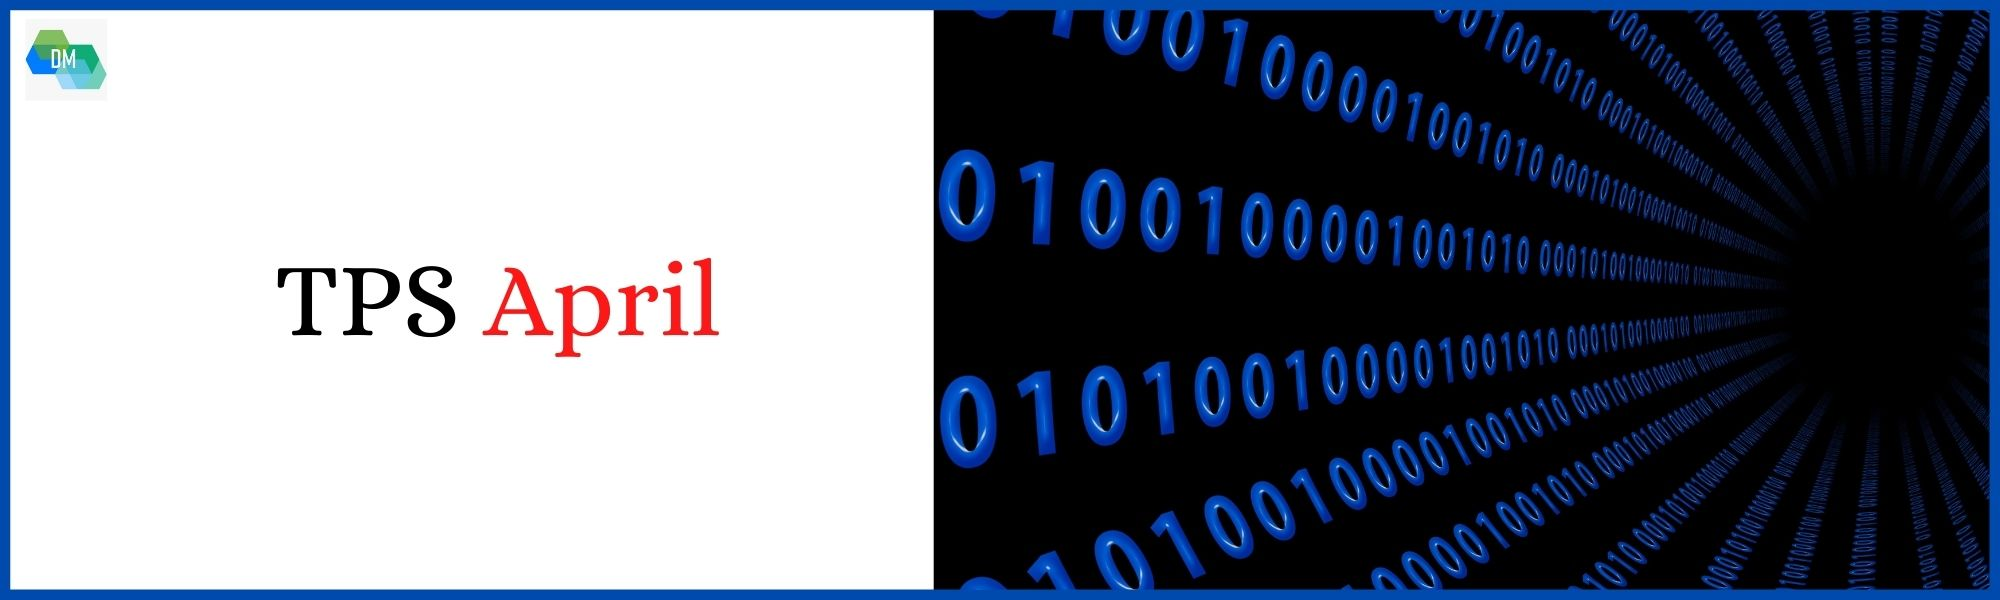

**Observations on this TPS dataset:**
- `state` column is the target variable which is associated to each sequence.

- `Train` dataset has `15,58,080` rows and `16` columns which contains`13` sensor columns, `1` subject id column, `1` time step recording column, and `1` column of `sequence id`
- `Test` dataset has `733,080` rows and `16` columns which contains`13` sensor columns, `1` subject id column, `1` time step recording column, and `1` column of `sequence id`
- `Train_labels` dataset has `25,968` rows which contains `target` column and `1` column of `sequence id`
- No missing values in train, test and train_labels dataset

**Training File Description:**

The training set, comprising `26,000` 60-second recordings of thirteen biological sensors for almost one thousand experimental participants.

- `sequence` - a unique id for each sequence
- `subject` - a unique id for the subject in the experiment
- `step` - time step of the recording, in one second intervals
- `sensor_00` - `sensor_12` - the value for each of the thirteen sensors at that time step

**Train Labels Description:**

This set comprises the class label for each sequence.

- `sequence` - the unique id for each sequence.
- `state` - the state associated to each sequence. This is the target which you are trying to predict.

**Test File**
: For each of the ~`12,000` sequences, you should predict a value for that sequence's state.

### <h3 style="background-color:#a2d2ff;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Importing Libraries & Packages 📚 </centre></strong></h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D

import warnings
warnings.filterwarnings('ignore')

2022-04-09 12:20:43.146710: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-09 12:20:43.146824: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### <h3 style="background-color:#a2d2ff;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Importing & Reading the dataset 📝 </centre></strong></h3>

In [2]:
df_train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
df_subm = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
df_labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")

In [3]:
df_train_row_count, df_train_column_count = df_train.shape
print('Total number of rows (Train):', df_train_row_count)
print('Total number of columns (Train):', df_train_column_count)

Total number of rows (Train): 1558080
Total number of columns (Train): 16


In [4]:
df_test_row_count, df_test_column_count = df_test.shape
print('Total number of rows (Test):', df_test_row_count)
print('Total number of columns (Test):', df_test_column_count)

Total number of rows (Test): 733080
Total number of columns (Test): 16


In [5]:
df_labels_row_count, df_labels_column_count = df_labels.shape
print('Total number of rows (Train Labels):', df_labels_row_count)
print('Total number of columns (Train Labels):', df_labels_column_count)

Total number of rows (Train Labels): 25968
Total number of columns (Train Labels): 2


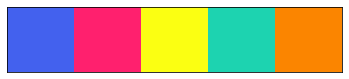

In [6]:
#Custom Color Palette 🎨
custom_colors = ["#4361ee","#ff206e","#fbff12","#1dd3b0","#fb8500"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

In [7]:
df_train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sequence,1558080.0,12983.500000,7496.318295,0.000000,6491.750000,12983.500000,19475.250000,25967.000000
subject,1558080.0,331.633087,195.825657,0.000000,161.750000,335.000000,501.000000,671.000000
step,1558080.0,29.500000,17.318108,0.000000,14.750000,29.500000,44.250000,59.000000
sensor_00,1558080.0,0.000437,2.658684,-375.063369,-0.500000,-0.003091,0.484544,335.824575
sensor_01,1558080.0,-0.001035,4.404200,-434.597689,-0.483193,0.003151,0.492647,449.591387
sensor_02,1558080.0,-0.217805,2.298002,-31.659476,-0.646153,0.000000,0.333847,1.666667
sensor_03,1558080.0,-0.002157,3.934184,-408.376106,-0.492920,0.000000,0.489381,436.650442
sensor_04,1558080.0,-0.001829,1.683685,-23.626013,-0.472993,-0.001590,0.470156,24.872865
sensor_05,1558080.0,-0.001652,1.590818,-74.982797,-0.478684,0.002992,0.505610,77.915482
sensor_06,1558080.0,-0.000412,3.345143,-470.504554,-0.492714,0.000911,0.492714,442.500911


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


### <h3 style="background-color:#a2d2ff;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Checking for missing values ✏️ </centre></strong></h3>

In [10]:
df_train.isna().sum()

sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

In [11]:
df_test.isna().sum()

sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

In [12]:
df_labels.isna().sum()

sequence    0
state       0
dtype: int64

In [13]:
print ("Unique values are:\n",df_train.nunique())

Unique values are:
 sequence      25968
subject         672
step             60
sensor_00     25792
sensor_01     28326
sensor_02      4771
sensor_03     26976
sensor_04    387971
sensor_05     22839
sensor_06     25078
sensor_07     28147
sensor_08      1924
sensor_09     30127
sensor_10    268478
sensor_11     28932
sensor_12    303949
dtype: int64


### <h3 style="background-color:#a2d2ff;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>EDA 🔍 </centre></strong></h3>

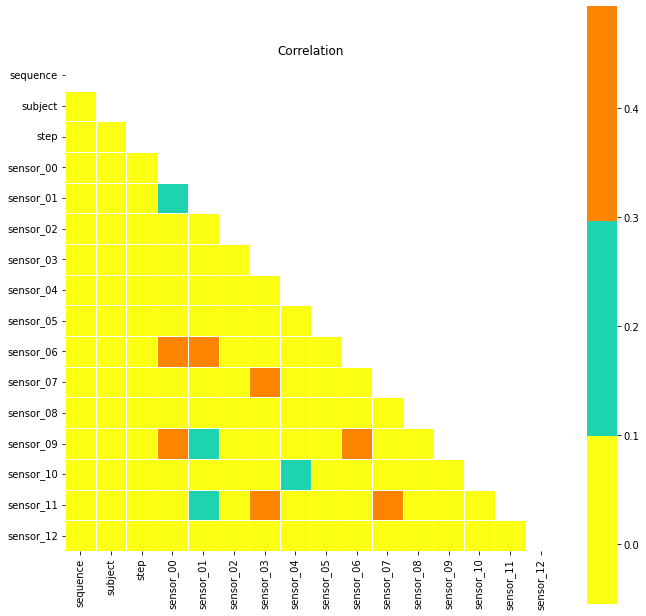

In [14]:
plt.figure(figsize=(11,11))
corr=df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=custom_colors, robust=True, center=0,square=True, linewidths=.6)
plt.title('Correlation')
plt.show()

In [15]:
df_labels['state'].value_counts()

1    13014
0    12954
Name: state, dtype: int64

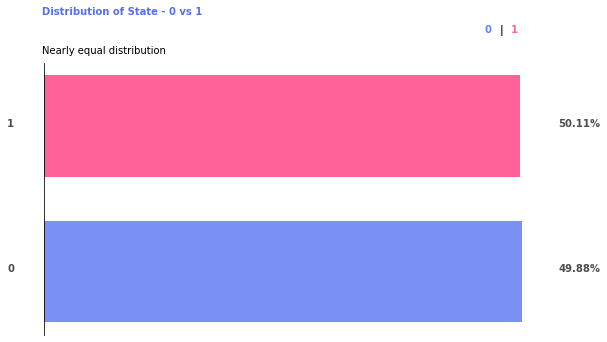

In [16]:
x = df_labels['state'].value_counts()

fig,ax=plt.subplots(figsize=(9,5))
ax.barh([1],x.values[1],height=0.7,color='#ff206e',alpha=0.7)
plt.text(-1000,1, '1', {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'},alpha = 0.7)
plt.text(14000,1, '50.11%', {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'},alpha = 0.7)

ax.barh([0],x.values[0],height=0.7,color='#4361ee',alpha=0.7)
plt.text(-1000,0,'0',{'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'}, alpha = 0.7)
plt.text(14000,0, '49.88%',{'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'}, alpha = 0.7)


plt.text(-50,1.77, 'Distribution of State - 0 vs 1',{'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'#4361ee'}, alpha = 0.9)
plt.text(12000,1.65, '0 ', {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'#4361ee'},alpha = 0.8)
plt.text(12400,1.65, '|', {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'}, alpha = 0.9)
plt.text(12700,1.65, '1',  {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'#ff206e'},alpha = 0.7)
plt.text(-50,1.5, 'Nearly equal distribution')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

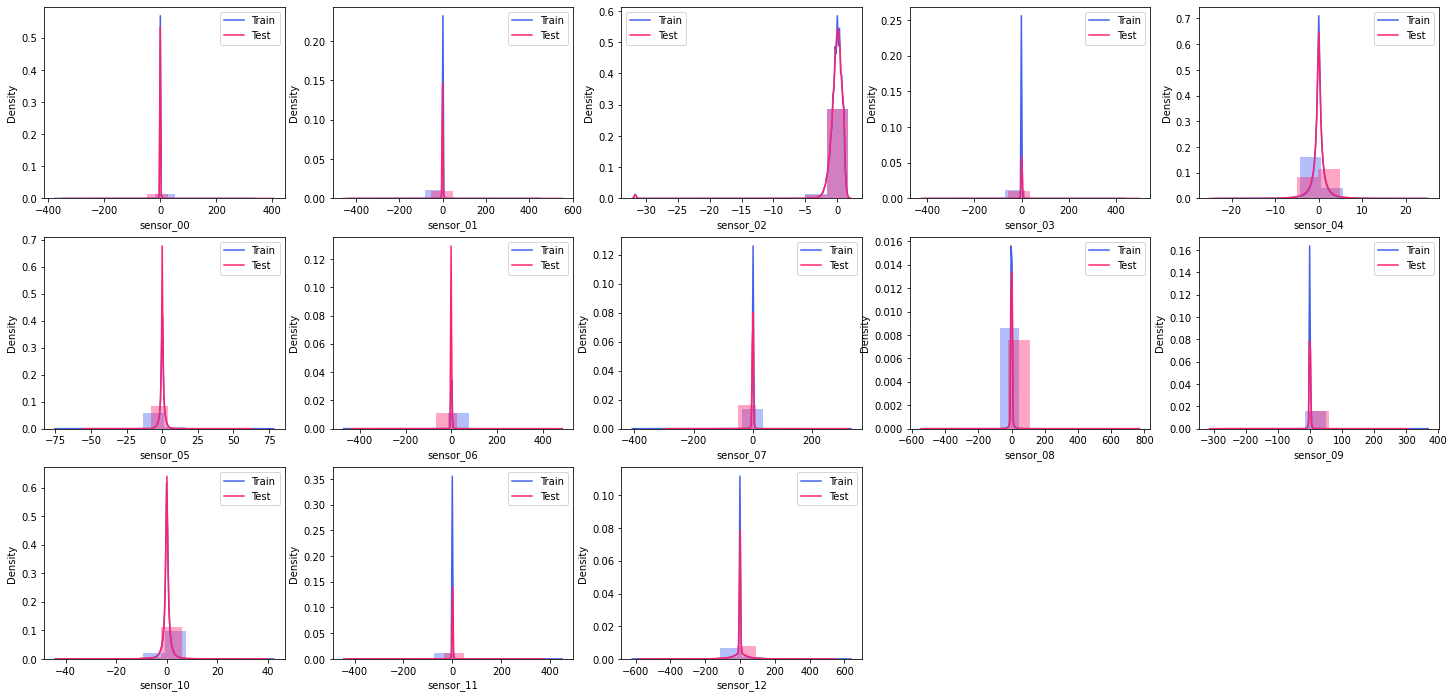

In [17]:
plt.figure(figsize=(25,12))
for i, col in enumerate(df_train.columns[3:]):
    fig = plt.subplot(3, 5, i+1)
    sns.distplot(df_train[col], bins = 10, color ='#4361ee')
    sns.distplot(df_test[col], bins = 10, color ='#ff206e')
    fig.legend(labels = ('Train','Test'))  

In [18]:
seq = df_train["sequence"]
df_train = df_train.drop(["sequence", "subject", "step"], inplace=False, axis=1).values
df_test = df_test.drop(["sequence", "subject", "step"], inplace=False, axis=1).values
df_labels = df_labels["state"]
sc = StandardScaler()
sc.fit(df_train)
df_train = sc.transform(df_train)
df_test = sc.transform(df_test)
df_train = df_train.reshape(int(len(df_train)/60), 60, 13)
df_test = df_test.reshape(int(len(df_test)/60), 60, 13)

### <h3 style="background-color:#a2d2ff;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>LSTM ⏳</centre></strong></h3>

In [19]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-04-09 12:23:00.983311: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-09 12:23:00.986765: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-09 12:23:00.986806: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-09 12:23:00.986836: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cf3d8e60ce7b): /proc/driver/nvidia/version does not exist
2022-04-09 12:23:00.990103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [20]:
# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = Sequential()
    model.add(LSTM(1024, return_sequences = True))
    model.add(LSTM(512, return_sequences = True))
    model.add(LSTM(256, return_sequences = True))
    model.add(LSTM(128, return_sequences = True))
    model.add(Conv1D(128, 3))
    model.add(MaxPooling1D())
    model.add(Conv1D(64, 3))
    model.add(MaxPooling1D())
    model.add(Conv1D(128, 3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation ='relu'))
    Dropout(0.2)
    model.add(Dense(1, activation ='sigmoid'))
    model.compile(optimizer ="adam", loss ="binary_crossentropy", metrics =["accuracy"])

In [21]:
cv = 0
pred = []
kfolds = GroupKFold(n_splits = 5)
for fold_idx, (train_idx, valid_idx) in enumerate(kfolds.split(df_train, df_labels, seq.unique())):
    print("*"*20, f"Fold {fold_idx+1}", "*"*20)
    X_train, X_valid = df_train[train_idx], df_train[valid_idx]
    y_train, y_valid = df_labels.iloc[train_idx].values, df_labels.iloc[valid_idx].values
    model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 100, batch_size = 256, 
              callbacks = [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True,verbose = 1)])
    cv += roc_auc_score(y_valid, model.predict(X_valid).squeeze())
    pred.append(model.predict(df_test))

******************** Fold 1 ********************
Epoch 1/100
82/82 [==============================] - 37s 143ms/step - loss: 0.6665 - accuracy: 0.6058 - val_loss: 0.5464 - val_accuracy: 0.7272
Epoch 2/100
82/82 [==============================] - 4s 47ms/step - loss: 0.5190 - accuracy: 0.7412 - val_loss: 0.4204 - val_accuracy: 0.8025
Epoch 3/100
82/82 [==============================] - 4s 50ms/step - loss: 0.4039 - accuracy: 0.8132 - val_loss: 0.4249 - val_accuracy: 0.8057
Epoch 4/100
82/82 [==============================] - 4s 48ms/step - loss: 0.3659 - accuracy: 0.8358 - val_loss: 0.4087 - val_accuracy: 0.8023
Epoch 5/100
82/82 [==============================] - 4s 47ms/step - loss: 0.3561 - accuracy: 0.8426 - val_loss: 0.3300 - val_accuracy: 0.8554
Epoch 6/100
82/82 [==============================] - 4s 47ms/step - loss: 0.3066 - accuracy: 0.8664 - val_loss: 0.3482 - val_accuracy: 0.8431
Epoch 7/100
82/82 [==============================] - 4s 47ms/step - loss: 0.2977 - accuracy: 0.86

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 1024)          4251648   
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 512)           3147776   
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 256)           787456    
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 128)           197120    
_________________________________________________________________
conv1d (Conv1D)              (None, 58, 128)           49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 64)            2

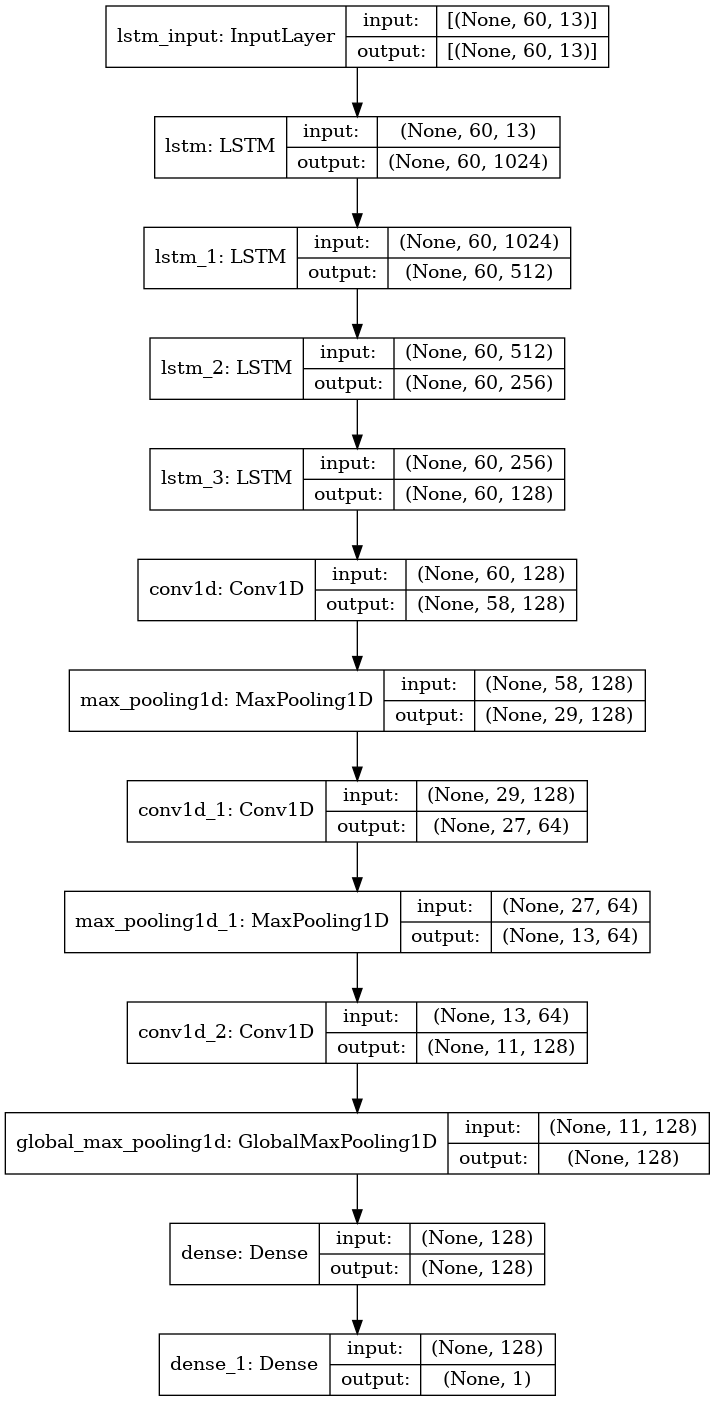

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
df_subm["state"] = sum(pred)/5
df_subm.to_csv("submission_lstm.csv", index=False)
df_subm

,sequence,state
0,25968,0.989414
1,25969,0.991678
2,25970,0.049061
3,25971,0.818280
4,25972,0.033877
...,...,...
12213,38181,0.032250
12214,38182,0.742119
12215,38183,0.208604
12216,38184,0.122677


### <h3 style="background-color:#a2d2ff;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>If you found this notebook useful, please Upvote. Thanks! </centre></strong></h3>